In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs Available:  1


In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [22]:
# content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
content_path = "/content/flower.jpg"
style_path = "/content/style_1.jpg"

In [23]:
content_path

'/content/flower.jpg'

In [24]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [25]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

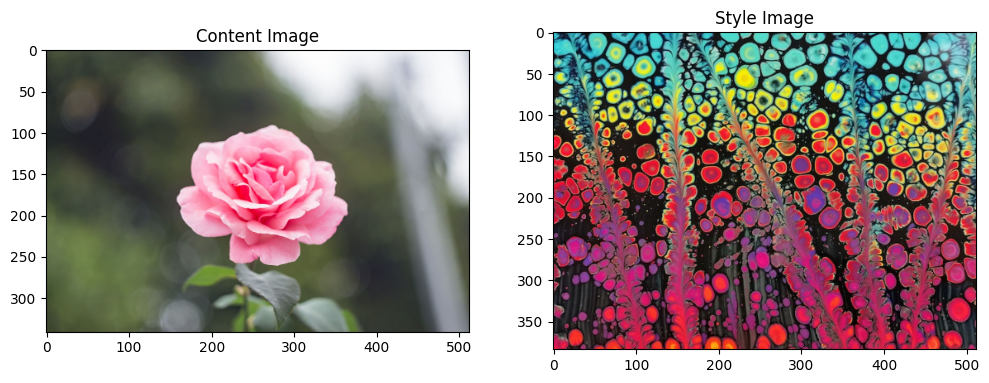

In [26]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

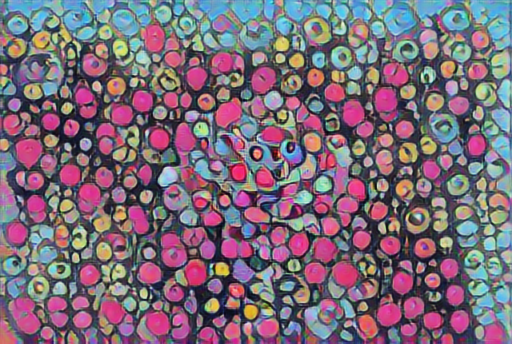

In [27]:
# Fast style transfer using tensorflow_hub
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [28]:
# Test run vgg19 on our image
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574710816/574710816 [==============================] - 20s 0us/step


TensorShape([1, 1000])

In [29]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 [==============================] - 0s 0us/step


[('picket_fence', 0.1617091),
 ('daisy', 0.1002857),
 ('bee', 0.0901412),
 ('cabbage_butterfly', 0.073473126),
 ('monarch', 0.038450032)]

In [30]:
vgg = tf.keras.applications.VGG19(include_top=False)

print()
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 [==============================] - 3s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [31]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [32]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]
  # print(outputs)

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [33]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 384, 512, 64)
  min:  0.0
  max:  718.23694
  mean:  36.19707

block2_conv1
  shape:  (1, 192, 256, 128)
  min:  0.0
  max:  4697.764
  mean:  216.31946

block3_conv1
  shape:  (1, 96, 128, 256)
  min:  0.0
  max:  9496.812
  mean:  265.70914

block4_conv1
  shape:  (1, 48, 64, 512)
  min:  0.0
  max:  23176.818
  mean:  784.4234

block5_conv1
  shape:  (1, 24, 32, 512)
  min:  0.0
  max:  3486.3047
  mean:  47.718548



In [34]:
# Batch sum
s = tf.random.normal(shape=[7,5,3])
t = tf.random.normal(shape=[7,3,2])
e = tf.einsum('bij,bjk->bik', s, t)
# output[a,i,k] = sum_j s[a,i,j] * t[a, j, k]
print(e.shape)

(7, 5, 2)


In [35]:
def gram_matrix(input_tensor):
  # Einsum is einstein summation
  # Ref: https://www.tensorflow.org/api_docs/python/tf/einsum
  # Sum of b_ijc * b_ijd to result in b_cd
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  # cast is type casting
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [36]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  # call is executed when the instance of this class is called
  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [37]:
# When called on an image, this model returns the gram matrix (style) of the style_layers and content of the content_layers
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))
print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.010189548
    max:  28028.322
    mean:  303.646

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  48887.78
    mean:  7842.3613

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  231253.16
    mean:  10197.278

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  5989688.0
    mean:  107746.48

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  51914.0
    mean:  653.8735

Contents:
   block5_conv2
    shape:  (1, 21, 32, 512)
    min:  0.0
    max:  758.01056
    mean:  8.961706


In [38]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [39]:
# Define a tf.Variable to contain the image to optimize.
# To make this quick, initialize it with the content image
# (the tf.Variable must be the same shape as the content image):
image = tf.Variable(content_image)

In [40]:
def clip_0_1(image):
  """
  Since this is a float image, define a function to keep the pixel values between 0 and 1:
  """
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [41]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [42]:
# The hyperparameters alpha and beta control the ratio of how much style versus content
style_weight=1e-2
content_weight=1e4

In [43]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    # print(content_outputs.keys())
    # print(style_outputs.keys())
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [44]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

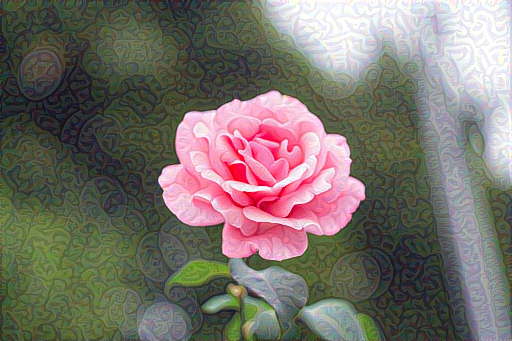

In [45]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

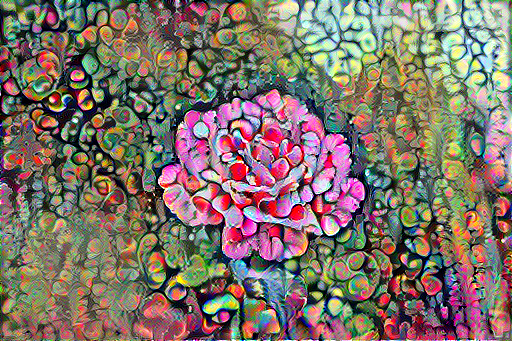

Train step: 1000
Total time: 61.8


In [46]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))